In [1]:
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py"
    import colab_helper
    colab_helper.install_idaes()
    colab_helper.install_ipopt()

--2025-08-30 14:00:57--  https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5459 (5.3K) [text/plain]
Saving to: ‘colab_helper.py’

colab_helper.py     100%[===================>]   5.33K  --.-KB/s    in 0s      

2025-08-30 14:00:57 (68.7 MB/s) - ‘colab_helper.py’ saved [5459/5459]

Installing idaes via pip...
idaes was successfully installed
idaes, version 2.8.0


Running idaes get-extensions to install Ipopt, k_aug, and more...
Checking solver versions:
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)



Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonl

In [2]:
import pyomo.environ as pyo
from pyomo.environ import *
import time
import pandas as pd
import re

   **MOFA implementation**   

In [3]:
Sij = pd.read_excel('/content/S_toymodel.xlsx', 'Sheet1',index_col=0) # stochiometric matrix

m= pd.read_excel('/content/S_toymodel.xlsx', 'Sheet3')
r= pd.read_excel('/content/S_toymodel.xlsx', 'Sheet2')
l=pd.read_excel('/content/S_toymodel.xlsx', 'Sheet4')
u=pd.read_excel('/content/S_toymodel.xlsx', 'Sheet5')

rxns=r['rxns'].tolist()
mets=m['mets'].tolist()
lb=l['lb'].tolist()
ub=u['ub'].tolist()

substring='EXCom_uptake'
indices = [i for i, s in enumerate(rxns) if substring in s]
uptake_rxns_indices = [rxns[i] for i in indices]

uptake_species1 = [n for n in uptake_rxns_indices if 'species1' in n]

uptake_species2=[n for n in uptake_rxns_indices if 'species2' in n]

substring='EXCom_export'
indices = [i for i, s in enumerate(rxns) if substring in s]
export_rxns_indices = [rxns[i] for i in indices]

big_M=1000000

Exc_indice = [i for i, s in enumerate(rxns) if 'EXCom_' in s]
Exc = [rxns[i] for i in Exc_indice]

F1=1
F2=1


model = ConcreteModel()

model.N = Set(initialize=rxns)

model.M = Set(initialize=mets)

biomass_id=['biomass_OrgP_species1','biomass_OrgQ_species2']

model.biomass = Set(initialize=biomass_id, within=model.N)

model.uptake_rxns_species1=Set(initialize=uptake_species1,within=model.N)

model.uptake_rxns_species2=Set(initialize=uptake_species2,within=model.N)

model.export_rxns=Set(initialize=export_rxns_indices,within=model.N)

    ##############################################################################################
    #              Create Parameters
    ##############################################################################################

model.lb = pyo.Param(model.N, initialize={rxn: lb[j]  for j, rxn in enumerate(rxns)})
model.ub = pyo.Param(model.N, initialize={rxn: ub[j]  for j, rxn in enumerate(rxns)})

    ##############################################################################################
    #              Create Variables
    ##############################################################################################

index_to_list = {k: i for i, k in enumerate(model.N)}

def variable_bounds_from_list(model, index):
  idx = index_to_list[index]
  lower_bound = lb[idx]
  upper_bound = ub[idx]

  return (lower_bound, upper_bound)

model.v = pyo.Var(model.N, bounds=variable_bounds_from_list)

model.u_1=pyo.Var(model.N)

model.lamda_1=pyo.Var(model.M)

model.eta_UB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)

model.eta_LB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)


model.u_2=pyo.Var(model.N)

model.lamda_2=pyo.Var(model.M)

model.eta_UB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

model.eta_LB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

##############################################################################################
    #                   The objective function
##############################################################################################

model.obj=pyo.Objective(expr=sum(model.v[i] for i in model.biomass), sense=pyo.maximize)

S = {(r, c): Sij.at[r, c] * ( F1 if 'species1' in c else F2 ) if c in Exc else Sij.at[r, c] for r in Sij.index for c in Sij.columns}

def massbalance_rule(model,m):
     return sum(S[m,n]*model.v[n] for n in model.N)==0
model.massbalance=pyo.Constraint(model.M,rule=massbalance_rule)

model.Biomass_species1=pyo.Constraint(expr=model.v[biomass_id[0]]== model.u_1[biomass_id[0]] )

model.Biomass_species2=pyo.Constraint(expr=model.v[biomass_id[1]]==model.u_2[biomass_id[1]] )

def Export_couple_Biomass_rule(model, export):
     if 'species1' in export:
        return model.v[export] <= big_M* model.v[biomass_id[0]]
     return model.v[export] <= big_M* model.v[biomass_id[1]]

model.Export_couple_biomass=pyo.Constraint(model.export_rxns,rule=Export_couple_Biomass_rule)


def Zero_const_species_rule(model, r):
    if r in uptake_rxns_indices:
        rr = r.replace('uptake', 'export')
        return model.v[r] * model.v[rr] == 0
    else:
        return pyo.Constraint.Skip

model.zero_species2 = pyo.Constraint(model.N, rule=Zero_const_species_rule)

##############################################################################################
    #                   (Inner-problem species1) constraint F.A for species 1
###############################################################################################
def massbalance_species1_rule(model,m):
     return sum(S[m,n]*model.u_1[n] for n in model.N)==0

model.massbalance_species1=pyo.Constraint(model.M,rule=massbalance_species1_rule)  #Su^1=0

def UB_const_species1_rule(model, r):
        if r not in model.uptake_rxns_species1:
            return model.u_1[r] <= model.ub[r]
        return  model.u_1[r] <= model.v[r]
model.ub_species1= pyo.Constraint(model.N, rule=UB_const_species1_rule)

def LB_const_species1_rule(model, r):
     return -1*model.u_1[r] <= -1*model.lb[r]
model.lb_species1= pyo.Constraint(model.N, rule=LB_const_species1_rule)


i_biomass=0;
def dual_const_species1_rule(model, n):
    if n not in  biomass_id[i_biomass]:
        return sum(S[m,n]*model.lamda_1[m] for m in model.M)+ model.eta_UB_1[n]-model.eta_LB_1[n]==0

    return sum(S[m,biomass_id[i_biomass]]*model.lamda_1[m] for m in model.M)+model.eta_UB_1[biomass_id[i_biomass]]-model.eta_LB_1[biomass_id[i_biomass]]==1

model.dual_species1= pyo.Constraint(model.N, rule=dual_const_species1_rule)

model.dual_eq_primal_species1=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_1[n] for n in model.uptake_rxns_species1)+ \
                  sum(-1*model.lb[n]*model.eta_LB_1[n]  for n in model.uptake_rxns_species1)+ \
                  sum(model.ub[n]*model.eta_UB_1[n] for n in model.N if n not in model.uptake_rxns_species1)+\
                  sum(-1*model.lb[n]*model.eta_LB_1[n] for n in model.N if n not in model.uptake_rxns_species1))==model.u_1[biomass_id[i_biomass]])

 ##############################################################################################
    #                   (Inner-problem species2) constraint F.A for species 2
###############################################################################################

def massbalance_species2_rule(model,m):
    return sum(S[m,n]*model.u_2[n] for n in model.N)==0
model.massbalance_species2=pyo.Constraint(model.M,rule=massbalance_species2_rule)

def UB_const_species2_rule(model, r):
    if r not in model.uptake_rxns_species2:
        return model.u_2[r] <= model.ub[r]
    return model.u_2[r] <= model.v[r]
model.ub_species2= pyo.Constraint(model.N, rule=UB_const_species2_rule)

def LB_const_species2_rule(model, r):
      return -1*model.u_2[r] <= -1*model.lb[r]
model.lb_species2= pyo.Constraint(model.N, rule=LB_const_species2_rule)

i_biomass=1;
def dual_const_species2_rule(model, n):
    if n not in  biomass_id[i_biomass]:
       return sum(S[m,n]*model.lamda_2[m] for m in model.M)+ model.eta_UB_2[n]-model.eta_LB_2[n]==0
    return sum(S[m,biomass_id[i_biomass]]*model.lamda_2[m] for m in model.M)+ \
            model.eta_UB_2[biomass_id[i_biomass]] -model.eta_LB_2[biomass_id[i_biomass]]==1

model.dual_species2= pyo.Constraint(model.N, rule=dual_const_species2_rule)

model.dual_eq_primal_species2=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_2[n] for n in model.uptake_rxns_species2)+ \
                  sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.uptake_rxns_species2)+ \
                  sum(model.ub[n]*model.eta_UB_2[n] for n in model.N if n not in model.uptake_rxns_species2)+\
                  sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.N if n not in model.uptake_rxns_species2))==model.u_2[biomass_id[i_biomass]])


start_time = time.time()
# solve using the nonlinear solver ipopt
result=SolverFactory('ipopt').solve(model)
#result=SolverFactory('bonmin').solve(model)
end_time = time.time()
execution_time = end_time - start_time
print(value(model.v[biomass_id[0]]),'   ',value(model.v[biomass_id[1]]),'  ',  value(model.obj))
print(f"Execution time: {execution_time:.6f} seconds", '  ', result.solver.status)

0.003147113582898093     355.7678850258521    355.77103213943496
Execution time: 0.128501 seconds    ok


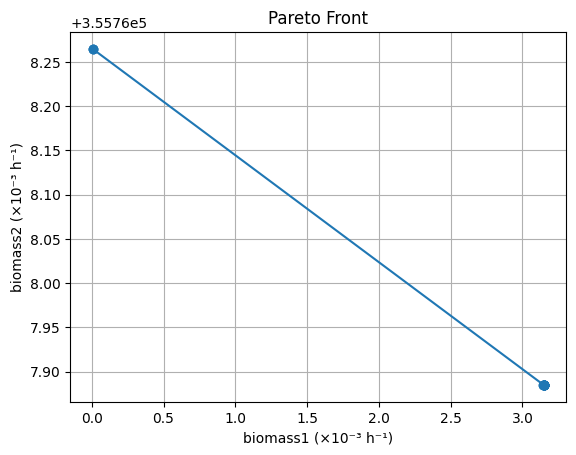

In [4]:
import matplotlib.pyplot as plt
import numpy as np

lambda_vals = np.linspace(0.1, 1, 20)

# Store results
pareto_V1 = []
pareto_V2 = []

for lam in lambda_vals:
  model = ConcreteModel()

  model.N = Set(initialize=rxns)

  model.M = Set(initialize=mets)

  biomass_id=['biomass_OrgP_species1','biomass_OrgQ_species2']

  model.biomass = Set(initialize=biomass_id, within=model.N)

  model.uptake_rxns_species1=Set(initialize=uptake_species1,within=model.N)

  model.uptake_rxns_species2=Set(initialize=uptake_species2,within=model.N)

  model.export_rxns=Set(initialize=export_rxns_indices,within=model.N)

    ##############################################################################################
    #              Create Parameters
    ##############################################################################################

  model.lb = pyo.Param(model.N, initialize={rxn: lb[j]  for j, rxn in enumerate(rxns)})
  model.ub = pyo.Param(model.N, initialize={rxn: ub[j]  for j, rxn in enumerate(rxns)})

    ##############################################################################################
    #              Create Variables
    ##############################################################################################

  index_to_list = {k: i for i, k in enumerate(model.N)}

  def variable_bounds_from_list(model, index):
    idx = index_to_list[index]
    lower_bound = lb[idx]
    upper_bound = ub[idx]

    return (lower_bound, upper_bound)

  model.v = pyo.Var(model.N, bounds=variable_bounds_from_list)

  model.u_1=pyo.Var(model.N)

  model.lamda_1=pyo.Var(model.M)

  model.eta_UB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)

  model.eta_LB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)


  model.u_2=pyo.Var(model.N)

  model.lamda_2=pyo.Var(model.M)

  model.eta_UB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

  model.eta_LB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

##############################################################################################
    #                   The objective function
##############################################################################################
  model.obj=pyo.Objective(expr=(1-lam)*model.v[biomass_id[0]]+lam*model.v[biomass_id[1]] , sense=pyo.maximize)
  S = {(r, c): Sij.at[r, c] * ( F1 if 'species1' in c else F2 ) if c in Exc else Sij.at[r, c] for r in Sij.index for c in Sij.columns}
#S = {(r, c):Sij.at[r,c] for r in  Sij.index for c in Sij.columns}

  def massbalance_rule(model,m):
     return sum(S[m,n]*model.v[n] for n in model.N)==0
  model.massbalance=pyo.Constraint(model.M,rule=massbalance_rule)

  model.Biomass_species1=pyo.Constraint(expr=model.v[biomass_id[0]]== model.u_1[biomass_id[0]] )

  model.Biomass_species2=pyo.Constraint(expr=model.v[biomass_id[1]]==model.u_2[biomass_id[1]] )
  big_M=100000000

  def Export_couple_Biomass_rule(model, export):
     if 'species1' in export:
        return model.v[export] <= big_M* model.v[biomass_id[0]]
     return model.v[export] <= big_M* model.v[biomass_id[1]]

  model.Export_couple_biomass=pyo.Constraint(model.export_rxns,rule=Export_couple_Biomass_rule)


  def Zero_const_species_rule(model, r):
    if r in uptake_rxns_indices:
        rr = r.replace('uptake', 'export')
        return model.v[r] * model.v[rr] == 0.000000000000000
    else:
        return pyo.Constraint.Skip

  model.zero_species2 = pyo.Constraint(model.N, rule=Zero_const_species_rule)

##############################################################################################
    #                   (Inner-problem species1) constraint F.A for species 1
###############################################################################################
  def massbalance_species1_rule(model,m):
     return sum(S[m,n]*model.u_1[n] for n in model.N)==0

  model.massbalance_species1=pyo.Constraint(model.M,rule=massbalance_species1_rule)  #Su^1=0

  def UB_const_species1_rule(model, r):
        if r not in model.uptake_rxns_species1:
            return model.u_1[r] <= model.ub[r]
        return  model.u_1[r] <= model.v[r]
  model.ub_species1= pyo.Constraint(model.N, rule=UB_const_species1_rule)

  def LB_const_species1_rule(model, r):
     return -1*model.u_1[r] <= -1*model.lb[r]
  model.lb_species1= pyo.Constraint(model.N, rule=LB_const_species1_rule)


  i_biomass=0;
  def dual_const_species1_rule(model, n):
    if n not in  biomass_id[i_biomass]:
        return sum(S[m,n]*model.lamda_1[m] for m in model.M)+ model.eta_UB_1[n]-model.eta_LB_1[n]==0

    return sum(S[m,biomass_id[i_biomass]]*model.lamda_1[m] for m in model.M)+model.eta_UB_1[biomass_id[i_biomass]]-model.eta_LB_1[biomass_id[i_biomass]]==1

  model.dual_species1= pyo.Constraint(model.N, rule=dual_const_species1_rule)

  model.dual_eq_primal_species1=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_1[n] for n in model.uptake_rxns_species1)+ \
                  sum(-1*model.lb[n]*model.eta_LB_1[n]  for n in model.uptake_rxns_species1)+ \
                  sum(model.ub[n]*model.eta_UB_1[n] for n in model.N if n not in model.uptake_rxns_species1)+\
                  sum(-1*model.lb[n]*model.eta_LB_1[n] for n in model.N if n not in model.uptake_rxns_species1))==model.u_1[biomass_id[i_biomass]])

 ##############################################################################################
    #                   (Inner-problem species2) constraint F.A for species 2
###############################################################################################

  def massbalance_species2_rule(model,m):
    return sum(S[m,n]*model.u_2[n] for n in model.N)==0
  model.massbalance_species2=pyo.Constraint(model.M,rule=massbalance_species2_rule)

  def UB_const_species2_rule(model, r):
    if r not in model.uptake_rxns_species2:
        return model.u_2[r] <= model.ub[r]
    return model.u_2[r] <= model.v[r]
  model.ub_species2= pyo.Constraint(model.N, rule=UB_const_species2_rule)

  def LB_const_species2_rule(model, r):
      return -1*model.u_2[r] <= -1*model.lb[r]
  model.lb_species2= pyo.Constraint(model.N, rule=LB_const_species2_rule)

  i_biomass=1;
  def dual_const_species2_rule(model, n):
    if n not in  biomass_id[i_biomass]:
       return sum(S[m,n]*model.lamda_2[m] for m in model.M)+ model.eta_UB_2[n]-model.eta_LB_2[n]==0
    return sum(S[m,biomass_id[i_biomass]]*model.lamda_2[m] for m in model.M)+ \
            model.eta_UB_2[biomass_id[i_biomass]] -model.eta_LB_2[biomass_id[i_biomass]]==1

  model.dual_species2= pyo.Constraint(model.N, rule=dual_const_species2_rule)

  model.dual_eq_primal_species2=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_2[n] for n in model.uptake_rxns_species2)+ \
                  sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.uptake_rxns_species2)+ \
                  sum(model.ub[n]*model.eta_UB_2[n] for n in model.N if n not in model.uptake_rxns_species2)+\
                  sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.N if n not in model.uptake_rxns_species2))==model.u_2[biomass_id[i_biomass]])

  solver = pyo.SolverFactory('ipopt')  # or 'glpk', etc.
  result = solver.solve(model, tee=False)
  pareto_V1.append(pyo.value(model.v[biomass_id[0]]))
  pareto_V2.append(pyo.value(model.v[biomass_id[1]]))

plt.plot(np.array(pareto_V1)*1e3, np.array(pareto_V2)*1e3, '-o')
plt.xlabel('biomass1 (×10⁻³ h⁻¹)')
plt.ylabel('biomass2 (×10⁻³ h⁻¹)')
plt.title('Pareto Front')
plt.grid(True)
plt.show()

**NECOM implementation**

In [6]:
import matplotlib.pyplot as plt
import numpy as np

Sij_1 = pd.read_excel('/content/S_organism_P_sbml.xls', 'Sheet1',index_col=0) # stochiometric matrix

m1= pd.read_excel('/content/S_organism_P_sbml.xls', 'Sheet3')
r1= pd.read_excel('/content/S_organism_P_sbml.xls', 'Sheet2')
l1=pd.read_excel('/content/S_organism_P_sbml.xls', 'Sheet4')
u1=pd.read_excel('/content/S_organism_P_sbml.xls', 'Sheet5')

rxns1=r1['rxns'].tolist()
mets1=m1['mets'].tolist()
lb1=l1['lb'].tolist()
ub1=u1['ub'].tolist()

Sij_2 = pd.read_excel('/content/S_organism_Q_sbml.xls', 'Sheet1',index_col=0) # stochiometric matrix

m2= pd.read_excel('/content/S_organism_Q_sbml.xls', 'Sheet3')
r2= pd.read_excel('/content/S_organism_Q_sbml.xls', 'Sheet2')
l2=pd.read_excel('/content/S_organism_Q_sbml.xls', 'Sheet4')
u2=pd.read_excel('/content/S_organism_Q_sbml.xls', 'Sheet5')

rxns2=r2['rxns'].tolist()
mets2=m2['mets'].tolist()
lb2=l2['lb'].tolist()
ub2=u2['ub'].tolist()

common_mets=['nh3[Extra_organism]','succ[Extra_organism]']


EXs1= [rxns1[i] for i in  [i for i, s in enumerate(rxns1) if 'EX_' in s]]
reactions_Of_common_mets1=[]
k=0
for i in range(len(common_mets)):
  for j in range(len(EXs1)):
    if(Sij_1.loc[common_mets[i]][EXs1[j]]!=0):

      nonzero_mets = Sij_1.loc[:, EXs1[j]] !=0
      #print(EXs1[j]) #v_comm
      result = [m for m in Sij_1.index[nonzero_mets] if '_[Env]' in m]

      V_up = (Sij_1.loc[result, :] > 0 )
      V_up_reactions = V_up.any(axis=0)
      reactions_list =[m for m in Sij_1.columns[V_up_reactions] if '_com_up' in m]

      reactions_Of_common_mets1.append([common_mets[i], EXs1[j], reactions_list])
      k=k+1

#print(reactions_Of_common_mets1[0])

EXs2= [rxns2[i] for i in  [i for i, s in enumerate(rxns2) if 'EX_' in s]]
reactions_Of_common_mets2=[]
k=0
for i in range(len(common_mets)):
  for j in range(len(EXs2)):
    if(Sij_2.loc[common_mets[i]][EXs2[j]]!=0):

      nonzero_mets = Sij_2.loc[:, EXs2[j]] !=0
      #print(EXs1[j]) #v_comm
      result = [m for m in Sij_2.index[nonzero_mets] if '_[Env]' in m]

      V_up = (Sij_2.loc[result, :] > 0 )
      V_up_reactions = V_up.any(axis=0)  # Boolean Series per column
      reactions_list =[m for m in Sij_2.columns[V_up_reactions] if '_com_up' in m]

      reactions_Of_common_mets2.append([common_mets[i], EXs2[j], reactions_list])
      k=k+1

#print(reactions_Of_common_mets2[0])

indices = [i for i, s in enumerate(rxns1) if '_com_up' in s]
uptake_rxns1= [rxns1[i] for i in indices]

indices = [i for i, s in enumerate(rxns2) if '_com_up' in s]
uptake_rxns2= [rxns2[i] for i in indices]

biomass_id=['biomass_OrgP','biomass_OrgQ']

X1=1
X2=1
M=1000

lambda_vals = np.linspace(0, 1, 20)

# Store results
pareto_V1 = []
pareto_V2 = []
status=[]


model = ConcreteModel()

model.N1 = Set(initialize=rxns1)
model.N2 = Set(initialize=rxns2)

model.M1 = Set(initialize=mets1)
model.M2 = Set(initialize=mets2)

model.uptake_rxns1=Set(initialize=uptake_rxns1,within=model.N1)
model.uptake_rxns2=Set(initialize=uptake_rxns2,within=model.N2)

model.lb1 = pyo.Param(model.N1, initialize={rxn: lb1[j]  for j, rxn in enumerate(rxns1)})
model.ub1 = pyo.Param(model.N1, initialize={rxn: ub1[j]  for j, rxn in enumerate(rxns1)})

model.lb2 = pyo.Param(model.N2, initialize={rxn: lb2[j]  for j, rxn in enumerate(rxns2)})
model.ub2 = pyo.Param(model.N2, initialize={rxn: ub2[j]  for j, rxn in enumerate(rxns2)})

model.v_1 = pyo.Var(model.N1)
model.v_2 = pyo.Var(model.N2)

model.Beta_1 = pyo.Var(model.N1)
model.Beta_2 = pyo.Var(model.N2)

model.lamda_1=pyo.Var(model.M1)
model.eta_UB_1=pyo.Var(model.N1,domain=pyo.NonNegativeReals)
model.eta_LB_1=pyo.Var(model.N1,domain=pyo.NonNegativeReals)

model.lamda_2=pyo.Var(model.M2)
model.eta_UB_2=pyo.Var(model.N2,domain=pyo.NonNegativeReals)
model.eta_LB_2=pyo.Var(model.N2,domain=pyo.NonNegativeReals)

reaction_ids_1 = [row[2] for row in reactions_Of_common_mets1]
model.up_com_rxn_1 = pyo.Set(initialize=reaction_ids_1)
model.delta_1 = pyo.Var(model.up_com_rxn_1, within=pyo.Binary)


reaction_ids_2 = [row[2] for row in reactions_Of_common_mets2]
model.up_com_rxn_2 = pyo.Set(initialize=reaction_ids_2)
model.delta_2 = pyo.Var(model.up_com_rxn_2, within=pyo.Binary)

model.obj=pyo.Objective(expr=(1-lam)*model.v_1['biomass_OrgP']+lam*model.v_2['biomass_OrgQ'], sense=pyo.maximize)

##############################################################################################
    #                   inner constraint for species 1
###############################################################################################
S1 = {(r, c):Sij_1.at[r,c] for r in  Sij_1.index for c in Sij_1.columns}

def massbalance_rule_species1(model,m):
   return sum(S1[m,n]*model.v_1[n] for n in model.N1)==0
model.massbalance_species1=pyo.Constraint(model.M1,rule=massbalance_rule_species1)

shared_rxns = set(rxn for row in reactions_Of_common_mets1 for rxn in row[2])

def LB_const_species1_rule(model, r):
        return -1*model.v_1[r] <= -1*model.lb1[r]
model.lb_species1= pyo.Constraint(model.N1, rule=LB_const_species1_rule)

def UB_uptake_const_species1_rule(model, r):
    if r in shared_rxns:
        return X1*model.v_1[r] <= model.Beta_1[r]
    return  model.v_1[r] <= model.ub1[r]
model.ub_uptake_species1= pyo.Constraint(model.N1, rule=UB_uptake_const_species1_rule)


##############################################################################################
    #                   Dual constraint for species 1
###############################################################################################

i_biomass=0;

def dual_const_species1_rule(model, n):
        if n not in  biomass_id[i_biomass]:
          if n not in shared_rxns:
            return sum(S1[m,n]*model.lamda_1[m] for m in model.M1)+ model.eta_UB_1[n]-model.eta_LB_1[n]==0
          else:
            return sum(S1[m,n]*model.lamda_1[m] for m in model.M1)+ X1*model.eta_UB_1[n]-model.eta_LB_1[n]==0
        else:
         return sum(S1[m,biomass_id[i_biomass]]*model.lamda_1[m] for m in model.M1)+ model.eta_UB_1[biomass_id[i_biomass]]-model.eta_LB_1[biomass_id[i_biomass]]==1
model.dual_species1= pyo.Constraint(model.N1, rule=dual_const_species1_rule)


model.dual_eq_primal_species1=pyo.Constraint(expr= (sum(model.Beta_1[n]*model.eta_UB_1[n] for n in shared_rxns)+ \
                  sum(-1*model.lb1[n]*model.eta_LB_1[n]  for n in shared_rxns)+ \
                  sum(model.ub1[n]*model.eta_UB_1[n] for n in model.N1 if n not in  shared_rxns)+\
                  sum(-1*model.lb1[n]*model.eta_LB_1[n] for n in model.N1 if n not in shared_rxns))==model.v_1[biomass_id[i_biomass]])

##############################################################################################
    #                   Binary constraint for species 1
###############################################################################################

def uptake_beta_UB_species1_rule(model,r):
    for row in reactions_Of_common_mets1:
        if r in row[2]:
          for equ in reactions_Of_common_mets2:
                if row[0] in equ[0]:
                    return model.Beta_1[row[2]]>=X2*model.v_2[equ[1]]
    return pyo.Constraint.Skip

model.uptake_beta_UB_species1=pyo.Constraint(model.up_com_rxn_1, rule=uptake_beta_UB_species1_rule)

def uptake_beta_LB_species1_rule(model,r):
    for row in reactions_Of_common_mets1:
        if r in row[2]:
           return model.Beta_1[row[2]]>=0
    return pyo.Constraint.Skip

model.uptake_beta_LB_species1=pyo.Constraint(model.up_com_rxn_1, rule=uptake_beta_LB_species1_rule)


def delta_up_LB_species1_rule(model,r):
   for row in reactions_Of_common_mets1:
        if r in row[2]:
          for equ in reactions_Of_common_mets2:
                if row[0] in equ[0]:
                    return model.Beta_1[row[2]]<= M*(model.delta_1[r])+X2*model.v_2[equ[1]]
   return pyo.Constraint.Skip
model.delta_up_LB_species1=pyo.Constraint(model.up_com_rxn_1, rule=delta_up_LB_species1_rule)

def delta_second_up_LB_species1_rule(model,r):
    return model.Beta_1[r]<= M*(1-model.delta_1[r])

model.delta_second_up_LB_species1=pyo.Constraint(model.up_com_rxn_1, rule=delta_second_up_LB_species1_rule)


##############################################################################################
    #                   inner constraint for species 2
###############################################################################################

S2 = {(r, c):Sij_2.at[r,c] for r in  Sij_2.index for c in Sij_2.columns}

def massbalance_rule_species2(model,m):
   return sum(S2[m,n]*model.v_2[n] for n in model.N2)==0
model.massbalance_species2=pyo.Constraint(model.M2,rule=massbalance_rule_species2)

def LB_const_species2_rule(model, r):
        return -1*model.v_2[r] <= -1*model.lb2[r]
model.lb_species2= pyo.Constraint(model.N2, rule=LB_const_species2_rule)

shared_rxns = set(rxn for row in reactions_Of_common_mets2 for rxn in row[2])
def UB_uptake_const_species2_rule(model, r):
    if r in shared_rxns:
        return X2*model.v_2[r] <= model.Beta_2[r]
    return model.v_2[r] <= model.ub2[r]
model.ub_uptake_species2= pyo.Constraint(model.N2, rule=UB_uptake_const_species2_rule)


##############################################################################################
    #                   Dual constraint for species 2
###############################################################################################

i_biomass=1;

def dual_const_species2_rule(model, n):
        if n not in  biomass_id[i_biomass]:
          #if n not in model.uptake_rxns2:
          if n not in shared_rxns:
            return sum(S2[m,n]*model.lamda_2[m] for m in model.M2)+ model.eta_UB_2[n]-model.eta_LB_2[n]==0
          else:
            return sum(S2[m,n]*model.lamda_2[m] for m in model.M2)+ X2*model.eta_UB_2[n]-model.eta_LB_2[n]==0
        else:
         return sum(S2[m,biomass_id[i_biomass]]*model.lamda_2[m] for m in model.M2)+ model.eta_UB_2[biomass_id[i_biomass]]-model.eta_LB_2[biomass_id[i_biomass]]==1
model.dual_species2= pyo.Constraint(model.N2, rule=dual_const_species2_rule)


model.dual_eq_primal_species2=pyo.Constraint(expr= (sum(model.Beta_2[n]*model.eta_UB_2[n] for n in shared_rxns)+ \
                  sum(-1*model.lb2[n]*model.eta_LB_2[n]  for n in shared_rxns)+ \
                  sum(model.ub2[n]*model.eta_UB_2[n] for n in model.N2 if n not in  shared_rxns)+\
                  sum(-1*model.lb2[n]*model.eta_LB_2[n] for n in model.N2 if n not in shared_rxns))==model.v_2[biomass_id[i_biomass]])

##############################################################################################
    #                   Binary constraint for species 2
###############################################################################################

def uptake_beta_UB_species2_rule(model,r):
    for row in reactions_Of_common_mets2:
        if r in row[2]:
          for equ in reactions_Of_common_mets1:
                if row[0] in equ[0]:
                    return model.Beta_2[row[2]]>=X1*model.v_1[equ[1]]
    return pyo.Constraint.Skip
model.uptake_beta_UB_species2=pyo.Constraint(model.up_com_rxn_2, rule=uptake_beta_UB_species2_rule)

def uptake_beta_LB_species2_rule(model,r):
    for row in reactions_Of_common_mets2:
        if r in row[2]:
           return model.Beta_2[row[2]]>=0
    return pyo.Constraint.Skip

model.uptake_beta_LB_species2=pyo.Constraint(model.up_com_rxn_2, rule=uptake_beta_LB_species1_rule)


def delta_up_LB_species2_rule(model,r):
    for row in reactions_Of_common_mets2:
        if r in row[2]:
          for equ in reactions_Of_common_mets1:
                if row[0] in equ[0]:
                    return model.Beta_2[row[2]]<= M*(model.delta_2[r])+X1*model.v_1[equ[1]]
    return pyo.Constraint.Skip
model.delta_up_LB_species2=pyo.Constraint(model.up_com_rxn_2, rule=delta_up_LB_species2_rule)

def delta_second_up_LB_species2_rule(model,r):
     return model.Beta_2[r]<= M*(1-model.delta_2[r])

model.delta_second_up_LB_species2=pyo.Constraint(model.up_com_rxn_2, rule=delta_second_up_LB_species2_rule)
start_time = time.time()
solver = pyo.SolverFactory('bonmin')  # or 'glpk', etc.
result = solver.solve(model, tee=False)

end_time = time.time()
execution_time = end_time - start_time
print(value(model.v_1[biomass_id[0]]),'   ',value(model.v_2[biomass_id[1]]),'  ',  value(model.obj))
print(f"Execution time: {execution_time:.6f} seconds", '  ', result.solver.status)

2.7244716234887045e-05     355.7682715959501    355.7682715959501
Execution time: 1.043380 seconds    ok


In [7]:
!apt-get install -y glpk-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 35 not upgraded.
Need to get 625 kB of archives.
After this operation, 2,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1:5.10.1+dfsg-4build1 [18.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libglpk40 amd64 5.0-1 [361 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 glpk-ut

**Joint FBA implementation**

In [8]:
model = ConcreteModel()

model.N = Set(initialize=rxns)

model.M = Set(initialize=mets)

biomass_id=['biomass_OrgP_species1','biomass_OrgQ_species2']

model.biomass = Set(initialize=biomass_id, within=model.N)

##############################################################################################
#              Create Parameters
##############################################################################################

model.lb = pyo.Param(model.N, initialize={rxn: lb[j]  for j, rxn in enumerate(rxns)})
model.ub = pyo.Param(model.N, initialize={rxn: ub[j]  for j, rxn in enumerate(rxns)})

##############################################################################################
#              Create Variables
##############################################################################################

index_to_list = {k: i for i, k in enumerate(model.N)}

def variable_bounds_from_list(model, index):
      idx = index_to_list[index]
      lower_bound = lb[idx]
      upper_bound = ub[idx]

      return (lower_bound, upper_bound)

model.v = pyo.Var(model.N, bounds=variable_bounds_from_list)


model.obj=pyo.Objective(expr=sum(model.v[i] for i in model.biomass), sense=pyo.maximize)

S = {(r, c):Sij.at[r,c] for r in  Sij.index for c in Sij.columns}

def massbalance_rule(model,m):
        return sum(S[m,n]*model.v[n] for n in model.N)==0
model.massbalance=pyo.Constraint(model.M,rule=massbalance_rule)

solver = pyo.SolverFactory('glpk', executable='/usr/bin/glpsol')
solver.solve(model)

print(value(model.v[biomass_id[0]]),'   ',value(model.v[biomass_id[1]]),'  ',  value(model.obj))


605.332742593539     0.0    605.332742593539
